Consider the evolution of a simple Hamiltonian into a problem-specific Hamiltonian where the optimal solution is 'encoded' in the ground state of the problem Hamiltonian $\displaystyle \hat{\mathcal{H}}_{\text{P}}$

$$\hat{\mathcal{H}}\left(s\right) = \left(1 - s\right)\hat{\mathcal{H}}_0 + s\underbrace{\left(\hat{\mathcal{H}}_{\text{A}} + \hat{\mathcal{H}}_{\text{B}}\right)}_{\hat{\mathcal{H}}_{\text{P}}}$$

for some $\displaystyle s = \frac{t}{T}$ where $T$ is the total computation time and

$$\hat{\mathcal{H}}_0 = -h_0\sum_i\sigma_x^i$$

and

$$\hat{\mathcal{H}}_{\text{P}} = \alpha\left[\sum_{j = 0}^{M - 1}2^jy_j + \left(c + 1 - 2^M\right)y_M - \sum_{i = 1}^nw_ix_i\right]^2,\qquad S\left(n\right) = O\left(n + \left\lfloor\log_2c\right\rfloor + 1\right)$$

where $\displaystyle \alpha > \max\left(p_j\right)$ and $\displaystyle M = \left\lfloor\log_2c\right\rfloor$ s.t. $2^{\ell + 1} \leq c < 2^{M + 1}$


In [1]:
from qutip import Qobj, basis, expect, ket2dm, mesolve, qeye, sigmax, sigmaz, tensor
import numpy as np
from matplotlib import gridspec
import matplotlib.pyplot as plt

np.set_printoptions(formatter={"all": lambda x: "{:.4g}".format(x)})

In [2]:
#   Tensor product such that i-th element is sigma_x and rest are identity
def tensor_sigmax(i: int, n: int) -> Qobj:
    ops = [qeye(2) for _ in range(n)]
    ops[i] = sigmax()
    return tensor(ops)


tensor_sigmax(0, 1)

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0 1]
 [1 0]]

In [3]:
#   Tensor product such that i-th element is (I - sigma_z) / 2 and rest are identity
def tensor_sigmaz(i: int, n: int) -> Qobj:
    ops = [qeye(2) for _ in range(n)]
    ops[i] = (qeye(2) - sigmaz()) / 2
    return tensor(ops)


tensor_sigmaz(0, 1)

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0 0]
 [0 1]]

In [4]:
#   Parameters to set
profits = np.array([6, 5, 8, 9, 6, 7, 3])
weights = np.array([2, 3, 6, 7, 5, 8, 4])
capacity = 9

#   Derived parameters
num_items = profits.shape[0]
alpha = np.max(profits) + 1
M = int(np.floor(np.log2(capacity)))

total_qubits = num_items + M + 1
num_states = np.power(2, total_qubits)

print(
    f"Total qubits: {num_items} (no. of items) + {M + 1} (ancillary qubits) = {total_qubits}"
)

Total qubits: 7 (no. of items) + 4 (ancillary qubits) = 11


In [5]:
#   Initial Hamiltonian H_0
# H_0 = sum(tensor_sigmaz(i, total_qubits) for i in range(total_qubits))

H_0 = 0
for i in range(total_qubits):
    for j in range(i + 1, total_qubits):
        # Pauli-X on the ith and jth qubit, identity on others
        operators = [qeye(2) if k != i and k != j else sigmax() for k in range(total_qubits)]
        H_0 -= tensor(operators)

H_0

Quantum object: dims=[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]], shape=(2048, 2048), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0 0 0 ... 0 0 0]
 [0 0 -1 ... 0 0 0]
 [0 -1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 -1 0]
 [0 0 0 ... -1 0 0]
 [0 0 0 ... 0 0 0]]

In [6]:
H_A1 = sum(
    np.power(2, j - num_items) * tensor_sigmaz(j, total_qubits)
    for j in range(num_items, num_items + M)
)  #   starting from the 1st ancillary qubit

H_A1

Quantum object: dims=[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]], shape=(2048, 2048), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 4 ... 0 0 0]
 ...
 [0 0 0 ... 3 0 0]
 [0 0 0 ... 0 7 0]
 [0 0 0 ... 0 0 7]]

In [7]:
H_A2 = (capacity + 1 - np.power(2, M)) * tensor_sigmaz(num_items + M, total_qubits)

H_A2

Quantum object: dims=[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]], shape=(2048, 2048), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 2]]

In [8]:
H_A3 = -sum(weights[i] * tensor_sigmaz(i, total_qubits) for i in range(num_items))

H_A3

Quantum object: dims=[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]], shape=(2048, 2048), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... -35 0 0]
 [0 0 0 ... 0 -35 0]
 [0 0 0 ... 0 0 -35]]

In [9]:
H_A = (H_A1 + H_A2 + H_A3) ** 2

H_A

Quantum object: dims=[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]], shape=(2048, 2048), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0 0 0 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 16 ... 0 0 0]
 ...
 [0 0 0 ... 900 0 0]
 [0 0 0 ... 0 784 0]
 [0 0 0 ... 0 0 676]]

In [10]:
H_B = -sum(profits[i] * tensor_sigmaz(i, total_qubits) for i in range(num_items))

H_B

Quantum object: dims=[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]], shape=(2048, 2048), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... -44 0 0]
 [0 0 0 ... 0 -44 0]
 [0 0 0 ... 0 0 -44]]

In [11]:
H_P = alpha * H_A + H_B

H_P

Quantum object: dims=[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]], shape=(2048, 2048), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0 0 0 ... 0 0 0]
 [0 40 0 ... 0 0 0]
 [0 0 160 ... 0 0 0]
 ...
 [0 0 0 ... 8956 0 0]
 [0 0 0 ... 0 7796 0]
 [0 0 0 ... 0 0 6716]]

In [12]:
eigenvalues, eigenstates = H_P.eigenstates()

np.sort(eigenvalues)

array([-15, -14, -14, ..., 1.085e+04, 1.152e+04, 1.221e+04], shape=(2048,))

In [13]:
#   Obtain the ground eigenstate of H_0
ground_eigenvalue, ground_eigenvector = H_0.groundstate()
psi0 = ground_eigenvector
print(f"Ground eigenvalue = {ground_eigenvalue}\nGround state:")

psi0

Ground eigenvalue = -55.00000000000003
Ground state:


c:\Users\raw_asparagus\AppData\Local\Programs\Python\Python312\Lib\site-packages\qutip\core\qobj.py:1623: UserWarning: Ground state may be degenerate.
  warnings.warn("Ground state may be degenerate.", UserWarning)


Quantum object: dims=[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], shape=(2048, 1), type='ket', dtype=Dense
Qobj data =
[[0.0001464]
 [-0.03125]
 [-0.03125]
 ...
 [0.0001464]
 [0.0001464]
 [-0.03125]]

In [14]:
times = np.linspace(0, 1, 10000)


#   Time-dependent Hamiltonian function
def H(s):
    return (1 - s) * H_0 + s * H_P


result = mesolve(H, psi0, times, e_ops=[])

In [15]:
def generate_basis_states(n):
    """Generates a list of all basis states for n qubits."""
    return [
        tensor([basis(2, (i >> m) % 2) for m in range(n - 1, -1, -1)])
        for i in range(num_states)
    ]


basis_states = generate_basis_states(total_qubits)

print("Basis states generated!\n")

Basis states generated!



In [16]:
basis_matrix = np.hstack([basis_state.full() for basis_state in basis_states])

state_matrix = np.hstack([psi.full() for psi in result.states])

probabilities = np.power(
    np.abs(np.dot(basis_matrix.T.conj(), state_matrix)), 2
).T.tolist()

print("Probabilities computed!\n")

Probabilities computed!



In [17]:
final_probabilities = [
    (format(idx, f"0{total_qubits}b"), prob)
    for idx, prob in enumerate(probabilities[-1])
]

print("Final probabilities formatted!\n")

Final probabilities formatted!



In [18]:
subset_times = np.linspace(0, 1, 100)

hamiltonians = [H(time) for time in subset_times]

eigenvalues = [ht.eigenenergies() for ht in hamiltonians]

all_eigenvalues = np.array([ev[:5] for ev in eigenvalues])

print("Energy eigenvalues computed!")

Energy eigenvalues computed!


In [19]:
# print("Final probabilities of each state:")
# for state_label, prob in final_probabilities:
#     print(f"| {state_label[0:num_items]} {state_label[num_items:]} >: {prob:.4f}")

In [20]:
sorted_probabilities = sorted(final_probabilities, key=lambda x: x[1], reverse=True)

num_item_bits = num_items
num_ancillary_bits = total_qubits - num_items
modifier_bit = total_qubits - 1


def calculate_item_weight(state_label):
    """Calculate total weight from item bits."""
    return sum(
        weights[i] for i, bit in enumerate(state_label[:num_item_bits]) if bit == "1"
    )


def calculate_ancillary_weight(state_label):
    """Calculate total weight from ancillary bits."""
    weight_from_ancillary = int(state_label[modifier_bit]) * (capacity - np.power(2, num_ancillary_bits - 2))
    for j in range(num_item_bits, num_item_bits + num_ancillary_bits - 1):
        if state_label[j] == "1":
            weight_from_ancillary += np.power(2, j - num_item_bits)
    return weight_from_ancillary


def calculate_total_profit(state_label):
    """Calculate total profit from item bits."""
    return sum(
        profits[i] for i, bit in enumerate(state_label[:num_items]) if bit == "1"
    )


print("States with the highest probabilities:")
for state_label, prob in sorted_probabilities[:5]:
    item_weight = calculate_item_weight(state_label)
    ancillary_weight = calculate_ancillary_weight(state_label)
    total_profit = calculate_total_profit(state_label)
    print(
        f"| {state_label[0:num_items]} {state_label[num_items:]} >: Probability = {prob:.4f}, "
        f"Item Weight = {item_weight}, Ancillary Weight = {ancillary_weight}, Total Profit = {total_profit}"
    )

States with the highest probabilities:
| 1100001 1111 >: Probability = 0.0771, Item Weight = 9, Ancillary Weight = 12, Total Profit = 14
| 1000100 1110 >: Probability = 0.0519, Item Weight = 7, Ancillary Weight = 7, Total Profit = 12
| 1000100 1011 >: Probability = 0.0519, Item Weight = 7, Ancillary Weight = 10, Total Profit = 12
| 0100100 0111 >: Probability = 0.0454, Item Weight = 8, Ancillary Weight = 11, Total Profit = 11
| 1010000 0111 >: Probability = 0.0452, Item Weight = 8, Ancillary Weight = 11, Total Profit = 14


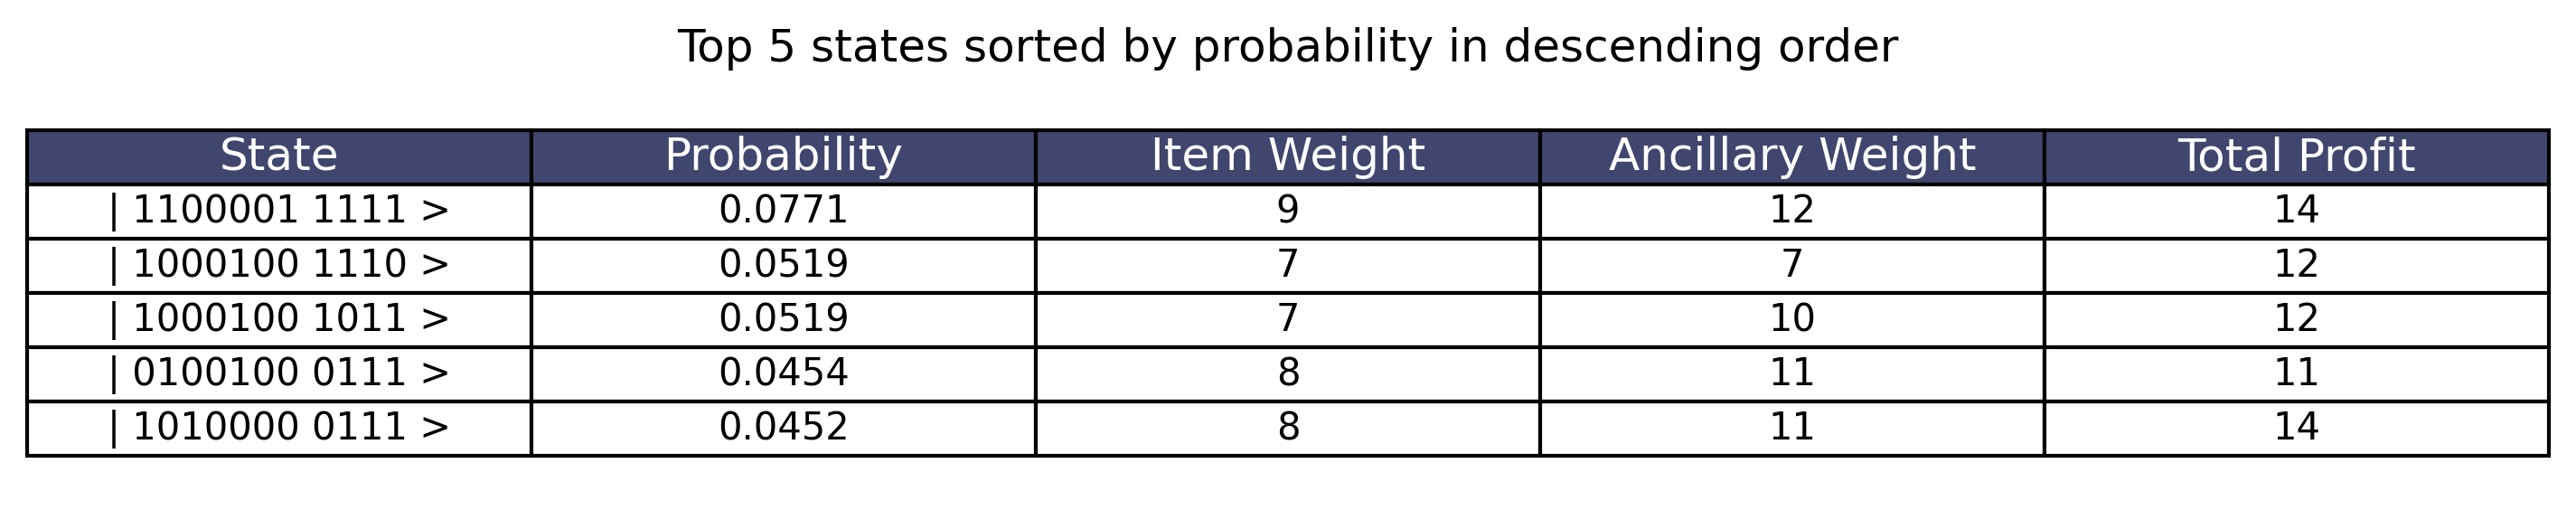

In [21]:
table_data = []
for state_label, prob in sorted_probabilities[:5]:
    item_weight = calculate_item_weight(state_label)
    ancillary_weight = calculate_ancillary_weight(state_label)
    total_profit = calculate_total_profit(state_label)
    table_data.append(
        [
            f"| {state_label[:num_items]} {state_label[num_items:]} >",
            f"{prob:.4f}",
            item_weight,
            ancillary_weight,
            total_profit,
        ]
    )


fig, ax = plt.subplots(figsize=(10, 2), dpi=300)
ax.axis("tight")
ax.axis("off")
ax.set(title="Top 5 states sorted by probability in descending order")
table = ax.table(
    cellText=table_data,
    colLabels=[
        "State",
        "Probability",
        "Item Weight",
        "Ancillary Weight",
        "Total Profit",
    ],
    cellLoc="center",
    loc="center",
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

for (i, j), cell in table.get_celld().items():
    if i == 0:
        cell.set_fontsize(12)
        cell.set_facecolor("#40466e")
        cell.set_text_props(color="w")

plt.show()

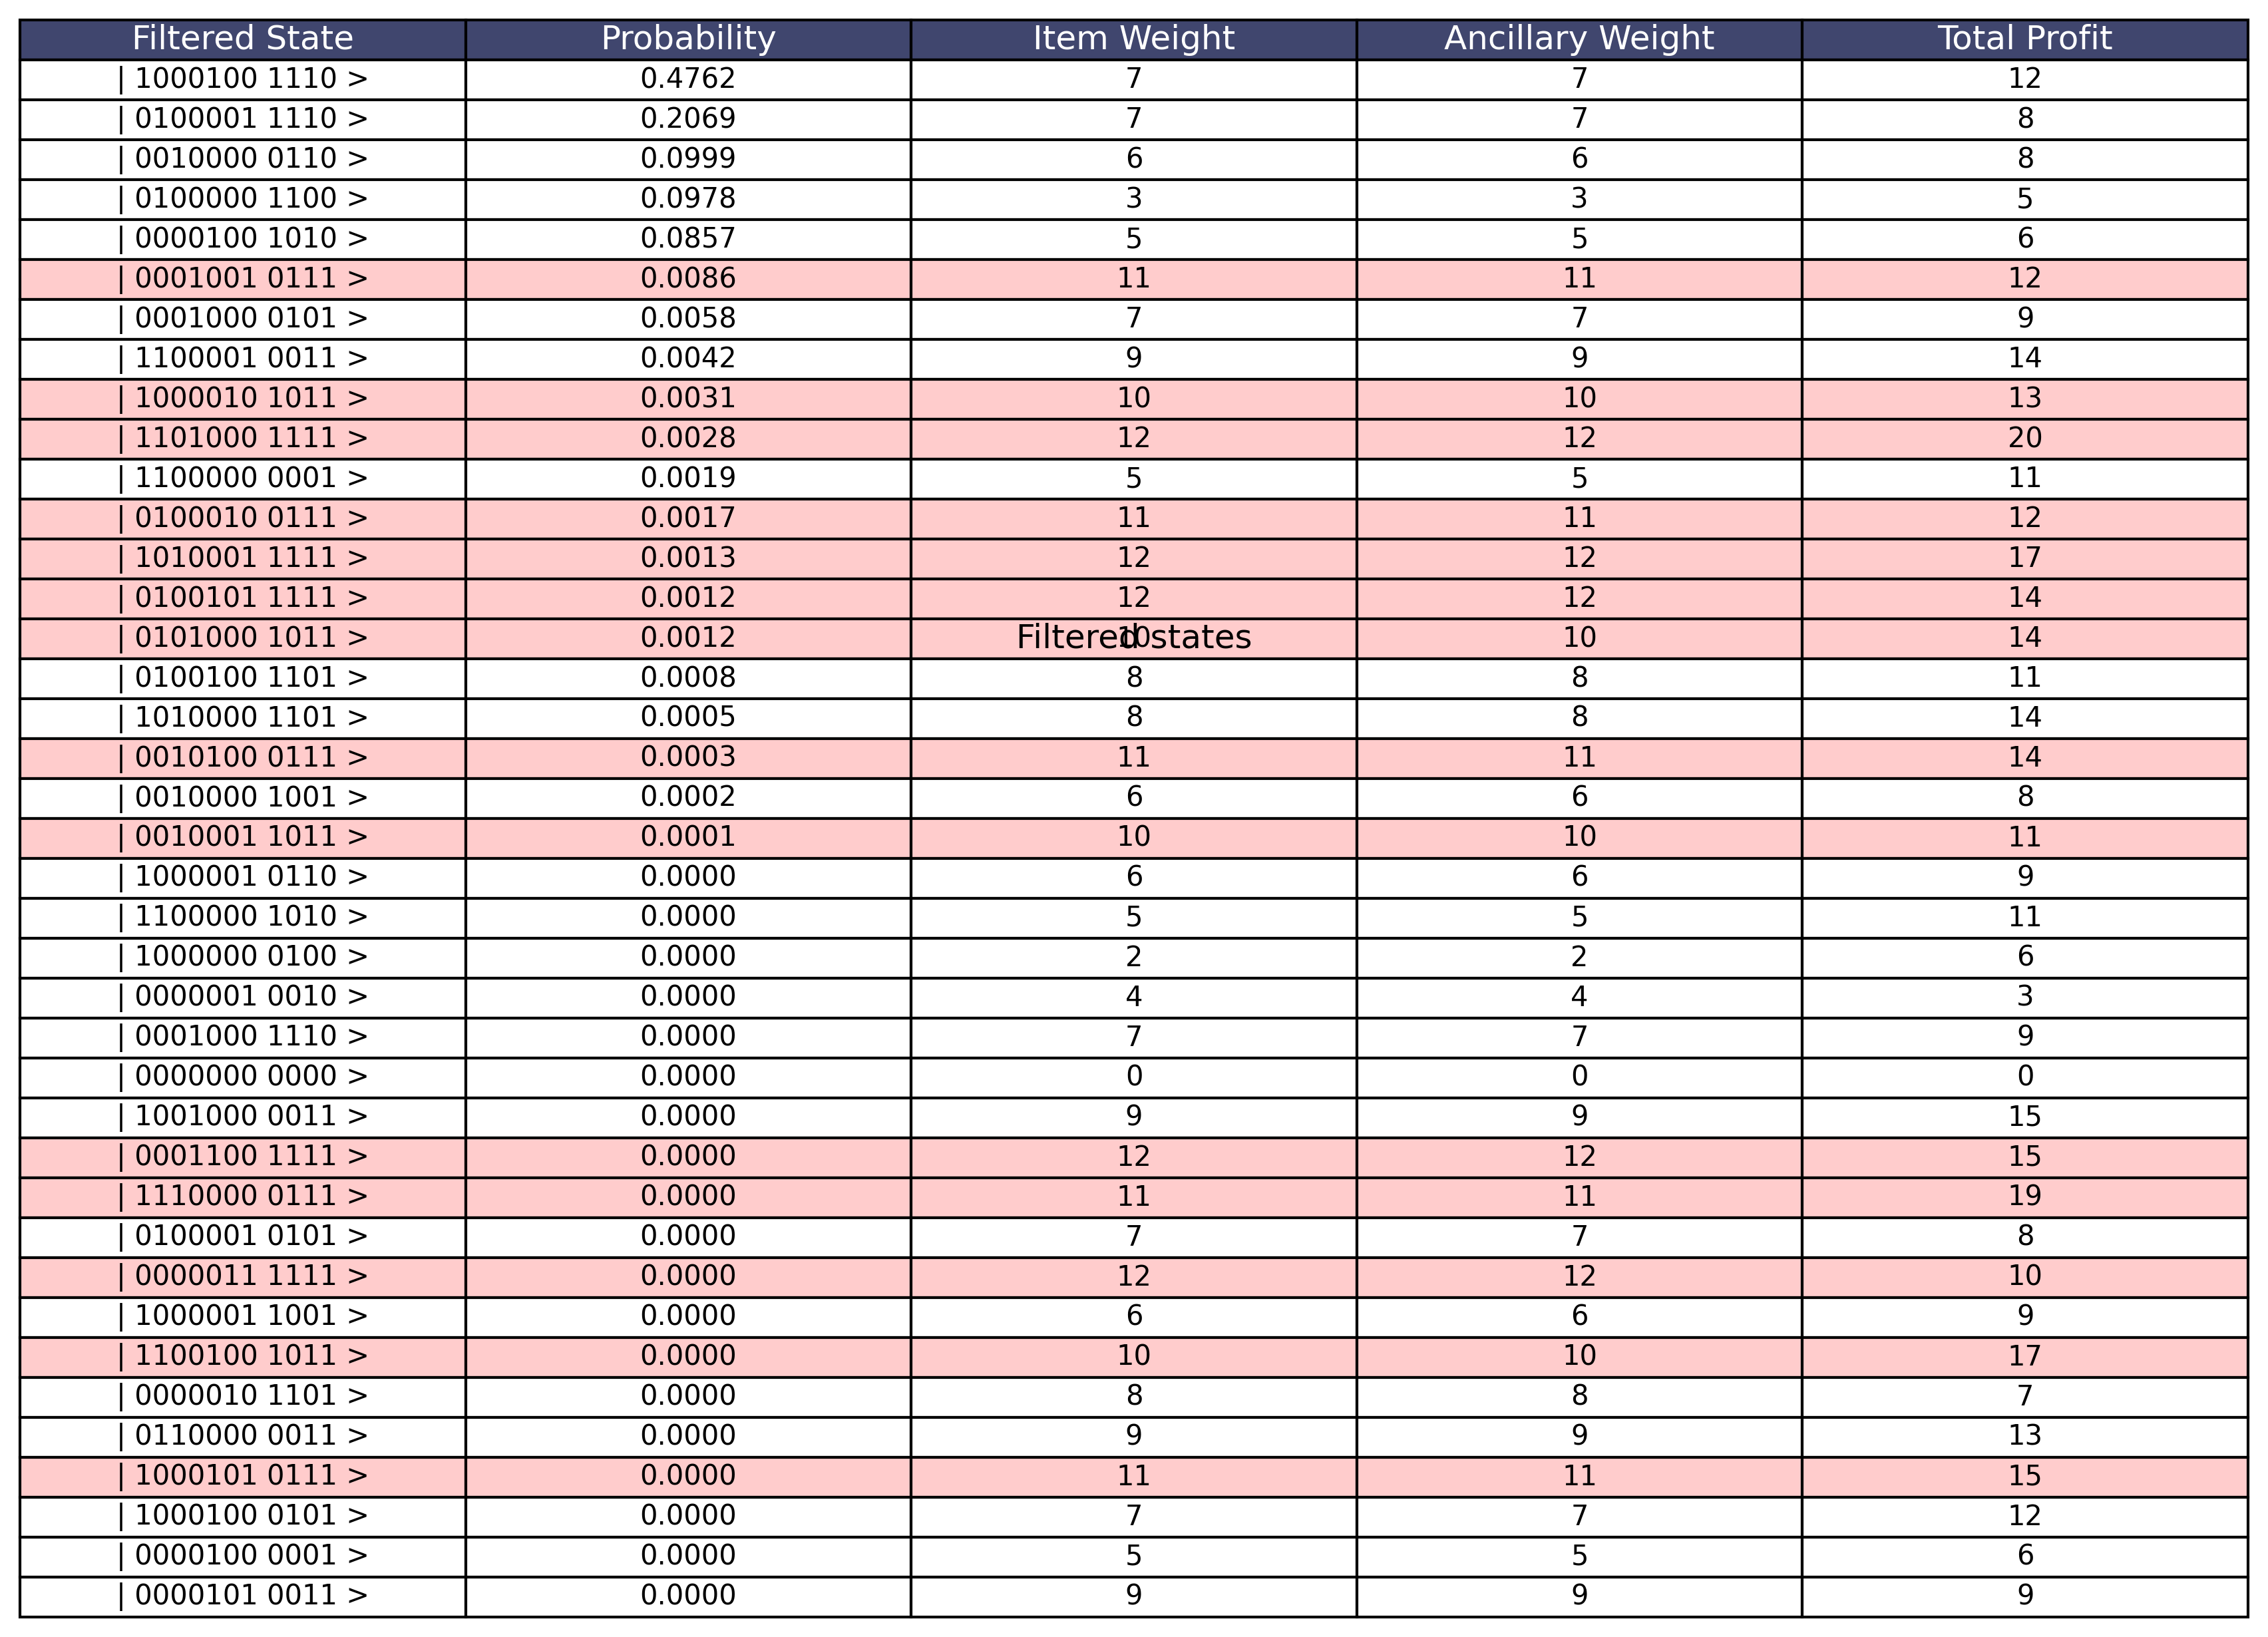

In [22]:
filtered_states = []
total_probability = 0

for state_label, prob in final_probabilities:
    item_weight = calculate_item_weight(state_label)
    ancillary_weight = calculate_ancillary_weight(state_label)
    total_profit = calculate_total_profit(state_label)
    if item_weight == ancillary_weight:
        filtered_states.append(
            (state_label, prob, item_weight, ancillary_weight, total_profit)
        )
        total_probability += prob

#   Normalize the probabilities of remaining states
normalized_states = [
    (label, prob / total_probability, item_weight, anc_weight, tot_profit)
    for label, prob, item_weight, anc_weight, tot_profit in filtered_states
]

sorted_normalized_states = sorted(normalized_states, key=lambda x: x[1], reverse=True)

fig, ax = plt.subplots(figsize=(12, 2), dpi=300)
ax.axis("tight")
ax.axis("off")
ax.set(title="Filtered states")
table_data = [
    [
        f"| {state[0][:num_items]} {state[0][num_items:]} >",
        f"{state[1]:.4f}",
        state[2],
        state[3],
        state[4],
    ]
    for state in sorted_normalized_states
]
table = ax.table(
    cellText=table_data,
    colLabels=[
        "Filtered State",
        "Probability",
        "Item Weight",
        "Ancillary Weight",
        "Total Profit",
    ],
    cellLoc="center",
    loc="center",
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

for (i, j), cell in table.get_celld().items():
    if i == 0:
        cell.set_fontsize(12)
        cell.set_facecolor("#40466e")
        cell.set_text_props(color="w")
    elif i > 0:
        item_weight = float(table_data[i - 1][2])
        if item_weight > capacity:
            for k in range(len(table_data[i - 1])):
                table[(i, k)].set_facecolor("#ffcccc")

plt.show()

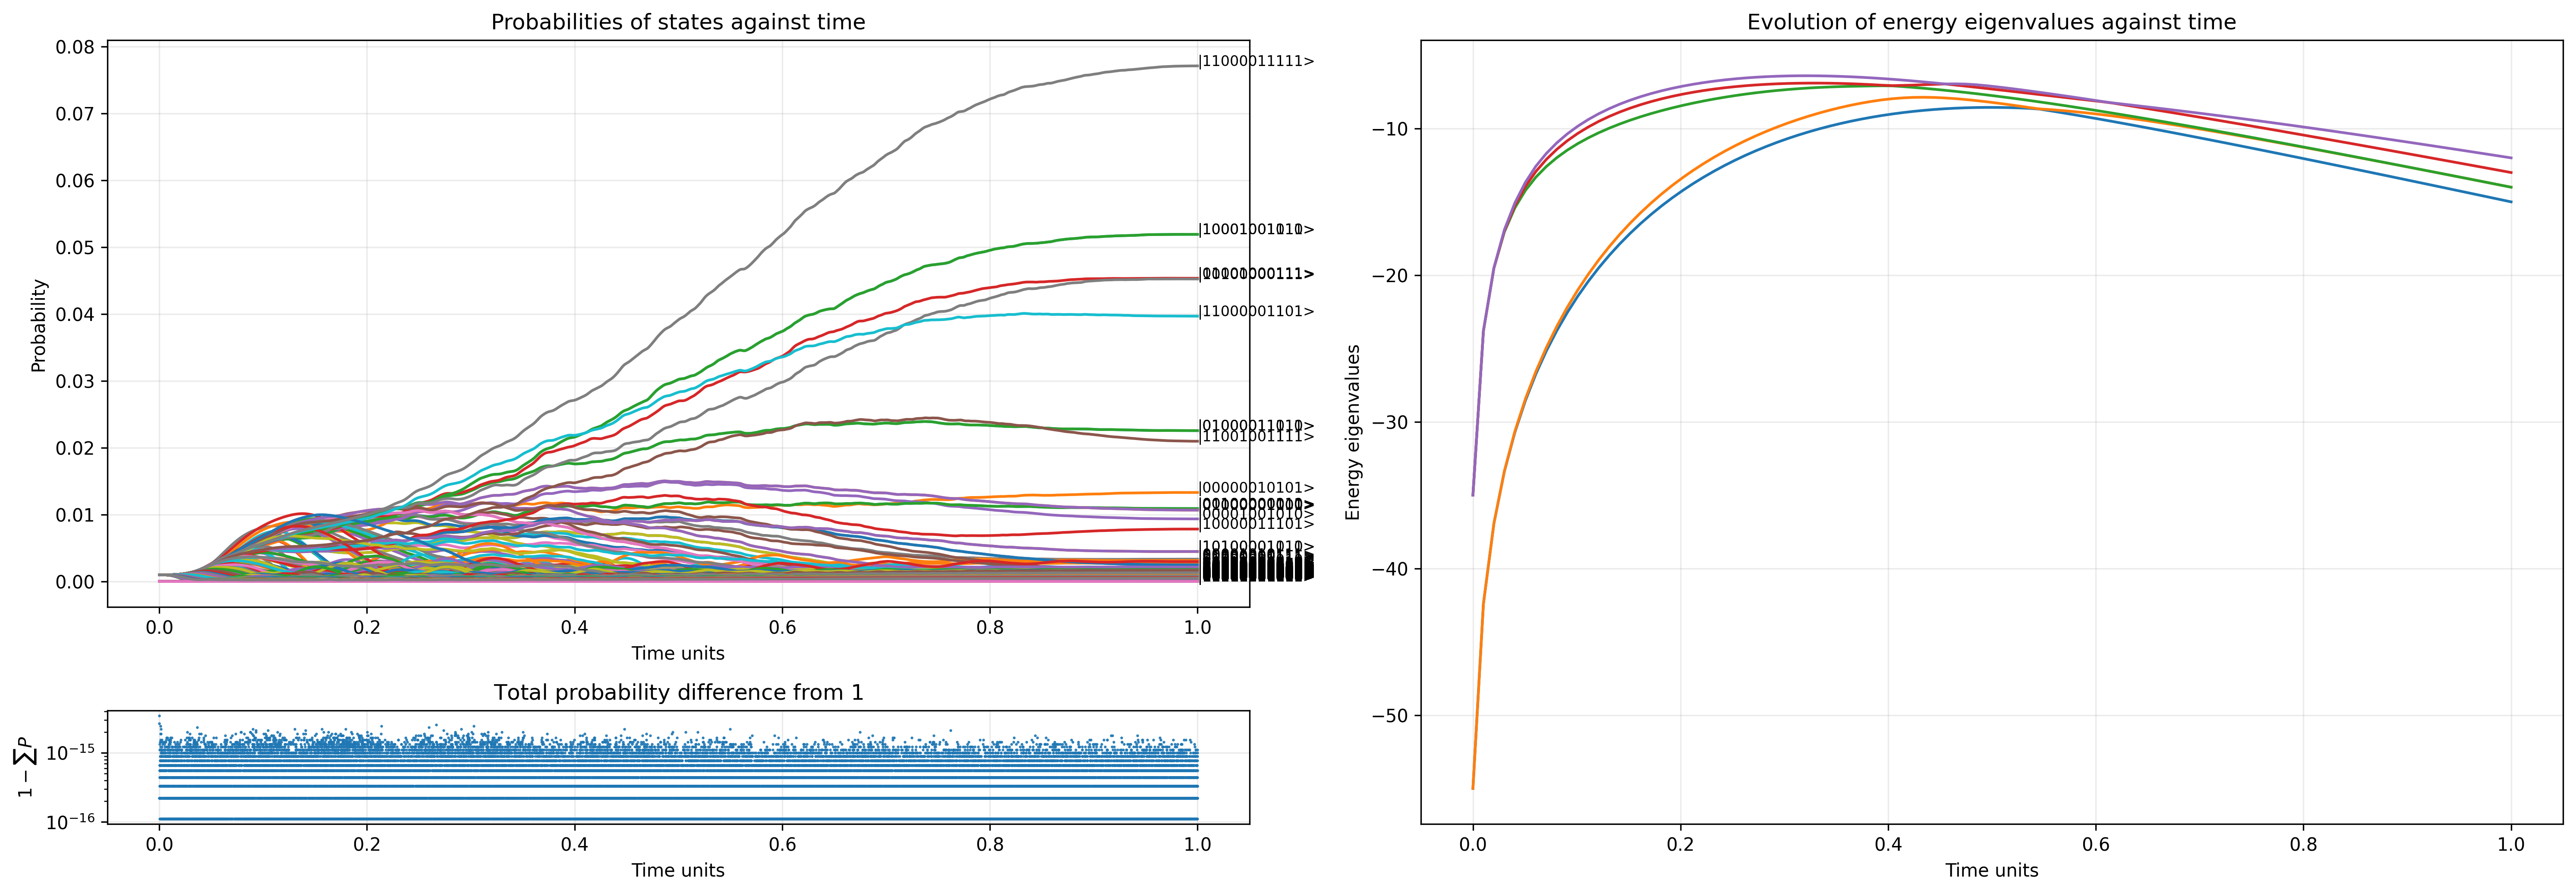

In [23]:
fig = plt.figure(figsize=(20, 7), dpi=300)
gs = gridspec.GridSpec(2, 2, height_ratios=[5, 1])

ax1 = fig.add_subplot(gs[0, 0])

for idx in range(num_states):
    ax1.plot(
        times,
        [prob[idx] for prob in probabilities],
        label=f'|{format(idx, "0" + str(total_qubits) + "b")}>',
    )
    ax1.text(
        times[-1],
        probabilities[-1][idx],
        f'|{format(idx, "0" + str(total_qubits) + "b")}>',
        fontsize=8,
    )

ax1.set(
    xlabel="Time units",
    ylabel="Probability",
    title="Probabilities of states against time",
)
ax1.grid(True, alpha=0.25)

ax3 = fig.add_subplot(gs[1, 0])

ax3.semilogy(times, [1 - sum(prob) for prob in probabilities], ls="", marker=".", ms=1)

ax3.set(
    xlabel="Time units",
    ylabel=r"$1 - \sum P$",
    title=r"Total probability difference from $1$",
)
ax3.grid(True, alpha=0.25)

ax2 = fig.add_subplot(gs[:, 1])

for idx in range(all_eigenvalues.shape[1]):
    ax2.plot(subset_times, all_eigenvalues[:, idx])

ax2.set(
    xlabel="Time units",
    ylabel="Energy eigenvalues",
    title="Evolution of energy eigenvalues against time",
)
ax2.grid(True, alpha=0.25)

plt.tight_layout()

plt.show()